In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import matplotlib.pyplot as plt

base_dir = '/content/gdrive/MyDrive/DATASET/'
classes = ['dark spots', 'puffy eyes', 'wrinkles', 'clear skin']
class_counts = {}

for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    count = len(os.listdir(class_path))
    class_counts[class_name] = count
    print(f"Class '{class_name}': {count} images")



Class 'dark spots': 301 images
Class 'puffy eyes': 300 images
Class 'wrinkles': 300 images
Class 'clear skin': 300 images


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from google.colab import drive

In [ ]:
data_dir = '/content/gdrive/MyDrive/DATASET/'
classes = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']
IMG_SIZE = 224
RANDOM_STATE = 42

In [ ]:
def load_images(data_dir, classes):
    """Loads images, resizes, and converts BGR to RGB."""
    data = []
    labels = []

    print("Starting image loading and resizing...")
    for idx, label in enumerate(classes):
        path = os.path.join(data_dir, label)
        if not os.path.exists(path):
            print(f"ERROR: Path not found: {path}")
            continue

        print(f"Processing class: {label}")
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                data.append(img.astype('float32'))
                labels.append(idx)
            else: print(f"Warning: Could not read image {img_name}")

    return np.array(data), np.array(labels)

In [ ]:
X, y = load_images(data_dir, classes)
X, y = shuffle(X, y, random_state=RANDOM_STATE)

y_encoded = to_categorical(y, num_classes=len(classes))

print(f"Images (X) shape: {X.shape} (Range [0, 255])")
print(f"Labels (y_encoded) shape: {y_encoded.shape} (One-Hot Encoded)")

Starting image loading and resizing...
Processing class: wrinkles
Processing class: dark spots
Processing class: puffy eyes
Processing class: clear skin
Images (X) shape: (1201, 224, 224, 3) (Range [0, 255])
Labels (y_encoded) shape: (1201, 4) (One-Hot Encoded)


/tmp/ipython-input-2492143423.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.countplot(x=label_names, palette="viridis")


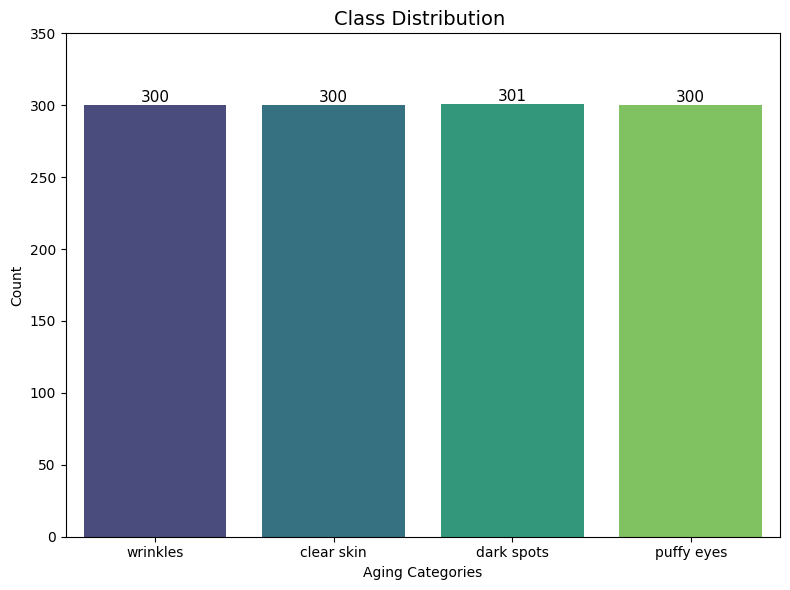

In [ ]:
label_names = [classes[i] for i in y]

plt.figure(figsize=(8, 6))
bars = sns.countplot(x=label_names, palette="viridis")
plt.title("Class Distribution ", fontsize=14)
plt.xlabel("Aging Categories")
plt.ylabel("Count")
plt.ylim(0, 350)

for bar in bars.patches:
    bars.annotate(f'{int(bar.get_height())}',
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='bottom', fontsize=11, color='black')

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/DATASET/class_distribution_plot.png')
plt.show()


 Augmentation
Displaying 5 augmented versions of a sample image:


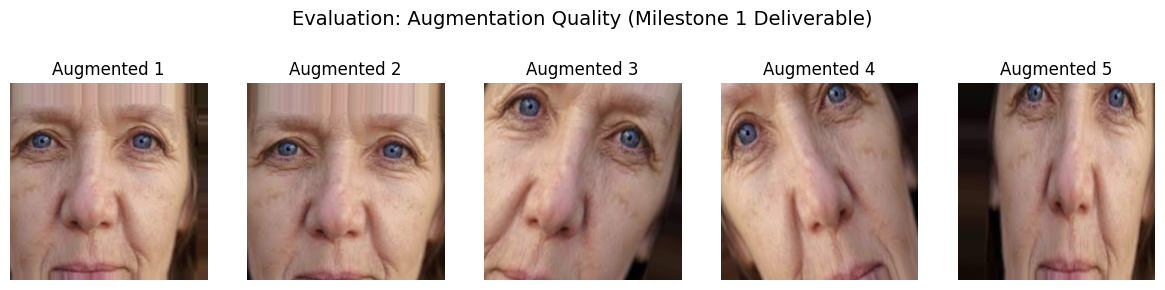

In [ ]:
print("\n Augmentation")
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

sample_img = X[0].reshape((1,) + X[0].shape)
i = 0
plt.figure(figsize=(12, 3))
print("Displaying 5 augmented versions of a sample image:")

for batch in datagen.flow(sample_img, batch_size=1):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0] / 255.0)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')
    i += 1
    if i >= 5:
        break

plt.suptitle("Evaluation: Augmentation Quality (Milestone 1 Deliverable)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('/content/gdrive/MyDrive/DATASET/class_distribution_plot.png')
plt.show()

In [ ]:
output_dir = '/content/gdrive/MyDrive/DATASET/'
np.save(os.path.join(output_dir, 'X_data_224_rgb.npy'), X)
np.save(os.path.join(output_dir, 'y_labels_one_hot.npy'), y_encoded)

print(f"Final preprocessed data saved to: {output_dir}")

Final preprocessed data saved to: /content/gdrive/MyDrive/DATASET/


In [ ]:
!pip install tensorflow


In [ ]:
import os

DATASET_PATH = "/content/gdrive/MyDrive/DATASET"  # your folder


In [ ]:
!ls /content/skin_split/train
!ls /content/skin_split/val


gdrive	sample_data


In [ ]:

import splitfolders

DATASET_PATH = "/content/gdrive/MyDrive/DATASET"   # Your dataset folder

splitfolders.ratio(DATASET_PATH,
                   output="/content/skin_split",  # New output folder
                   seed=42,
                   ratio=(0.8, 0.2))              # 80% Train, 20% Validation


Copying files: 1201 files [00:07, 163.64 files/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "/content/skin_split/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_data = val_datagen.flow_from_directory(
    "/content/skin_split/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')


Found 960 images belonging to 4 classes.
Found 241 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=15)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.2516 - loss: 1.4052 - val_accuracy: 0.2241 - val_loss: 1.3859
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.2696 - loss: 1.3931 - val_accuracy: 0.2490 - val_loss: 1.3865
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.2360 - loss: 1.3992 - val_accuracy: 0.1245 - val_loss: 1.3858
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.2602 - loss: 1.4077 - val_accuracy: 0.2531 - val_loss: 1.3858
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.2509 - loss: 1.4008 - val_accuracy: 0.2490 - val_loss: 1.3859
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.2345 - loss: 1.4050 - val_accuracy: 0.2407 - val_loss: 1.3861
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.2439 - loss: 1.4011 - val_accuracy: 0.2490 - val_loss: 1.3861
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.3012 - loss: 1.3812 - val_accuracy: 0.2490 - v

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/skin_classifier_effnetb0.h5"
model.save(MODEL_SAVE_PATH)

print("Model saved to:", MODEL_SAVE_PATH)


In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
